# Full Automated Pipeline: READ ME

*   Before executing the pipeline, run the code block immediately below this header (Installing External Libraries), which is used for installing libraries for text feature engineering. After running that code block, restart runtime and comment out the code block

*   To execute the pipeline, refer to the 2nd code block under this header (Global Parameters). In this code block, follow the instructions and decide whether to make the "global_upload" variable "True" or "False." If "True", specify the path for the downloaded csv. If "False", choose a path where the script will download the scraped images to later post and upload them to Imagga's API (posting, as opposed to doing a 'get' request, is the only way Imagga will process so many images). In addition, input your api_key and api_secret, as well as your Twitter bearer_token below.

*   NOTE: The reason you need to specify a path to an empty folder in Drive is because the Imagga API endpoint functions much better when posting downloaded images, rather than doing a 'get' request for Imagga to search the image online. We ran into numerous issues when using the 'get' request (even when specifying the function call to wait 5 - 10 seconds after each reqeust. Thus, we made the decision to download the images, then do a 'post' request. 


*   NOTE: Scraping the data live, rather than running the CSV, takes approximately 20-25 minutes, due to the time it takes to scrape the images from the news' outlets respective websites and the time it takes to make posts to Imagga's API for image processing. (99% of the tweets from our sample of media outlets did not upload images, rather, they used twitter cards, which appear like images, but are links to the media outlets' websites. For more information, see here, https://developer.twitter.com/en/docs/twitter-for-websites/cards/guides/getting-started)



*   Now, click Run All










In [ ]:
# Installing External Libraries
!pip install pyLDAvis
!pip install pyLDAvis.gensim
!pip install logging
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

In [ ]:
## Global Parameters ##

# Specify whether you want to upload a CSV or Scrape the Dataset ('True' means upload data set, 'False' means scrape data set)
global_upload = False
global_repeat_k_fold = False # False to run models quicker, True repeats the cross-fold validatation

if global_upload:
  # If uploading, specify your path to dataset
  global_path_twitter_csv = ''

else:
  # Path to download scraped images to an empty folder and upload them to Imagga API endpoint
  global_path_string_parameter = '/content/drive/MyDrive/Colab Notebooks/Data sets/final_df.csv'

  # Imagga API keys, ADD API KEY AND SECRET
  global_api_key_parameter =''
  global_api_secret_parameter=''

  # Specify how many tweets per twitter account you want scraped initially - 10 accounts
  global_tweets_per_account = 100 

  # After grabbing 'global_tweets_per_account' amount of tweets for each account, specify how many to keep (i.e. a value of 50 means the oldest 50 tweets from each account)
  global_tweets_last_n_keep = 5 # recommend 5 - 10 for testing purposes - 50 for data set w/ ~ 500 instances
  global_twitter_handles = ['CNN', 'MSNBC', 'FoxNews', 'newsmax', 'democracynow', 'WSJ', 'nytimes', 'voxdotcom', 'nypost', 'BreitbartNews']

# Trigger Function of API Data Scraping Pipeline

In [ ]:
def execute_api_data_scrape(global_path_string_parameter, 
                            global_api_key_paramter, 
                            global_api_secret_parameter, 
                            twitter_handles_news, 
                            num_orig_tweets=100, 
                            keep_tweets=10):
  
    ## SCRAPING DATA FROM TWITTER
    print("SCRAPING DATA FROM TWITTER - PART 1/4")
    df = scrape_tweets(twitter_handles_news, num_orig_tweets)
    df = return_last_n_tweets(df, n=keep_tweets)
    df = fixing_dataframe(df)
    df = delete_tweets_with_videos(df)
    df = convert_column_types_fix_index(df)
    print("----------------------------\n")


    ## CONVERTING TWITTER CARD IMAGES TO DOWNLOADABLE FILES
    print("CONVERTING TWITTER CARD IMAGES TO DOWNLOADABLE FILES - PART 2/4")
    df_new = df.copy()
    new_url_list = fix_urls(df_new)
    df_new = scrape_images_from_twitter_card(df_new, new_url_list)
    df_new = df_new[df_new['url_image_link'] != ''] # remove records that do not have any images
    # print(df_new.shape)
    df_new['author_name'].value_counts()
    # print()
    print("----------------------------\n")



    ## DOWNLOAD FILES AND POST IMAGES TO IMAGGA API ENDPOINT - EXTRACT FEATURES FROM TAGS
    print("DOWNLOADING FILES -  PART 3/4")
    print(download_images(df_new, path_string=global_path_string_parameter)) 
    print()
    print("----------------------------\n")

    # Post images to Imagga API
    print("POSTING IMAGES TO IMAGGA API ENDPOINT - PART 4/4")
    all_tags_json_list = post_to_imagga(api_key=global_api_key_paramter, 
                                        api_secret=global_api_secret_parameter,
                                        path_string=global_path_string_parameter,
                                        error_handling_attempt=False)

    # Get tag list
    tag_list = get_tag_list(all_tags_json_list)

    # Count frequency and make into dictionary
    top_n_tags = get_sorted_list(tag_list, 20)
    dict_top_n = convert_dict(top_n_tags)

    # Make image dataframe for image feature engineering
    image_df = create_image_df(dict_top_n, all_tags_json_list)
    image_df.columns = image_df.columns.map(''.join) # removing multi indexes


    # Check any errors posting images, if any
    successful_indexes = error_checking(all_tags_json_list)
    image_df['index'] = successful_indexes
    import pandas as pd
    image_df = image_df.apply(pd.to_numeric)
    

    return df_new, image_df

## Scraping Data from Twitter

In [ ]:
# Get user id of each News Outlet's username
def get_user_data(username, headers):
  import requests
  import json
  url = "https://api.twitter.com/2/users/by/username/" + username
  response = requests.request("GET", url, headers=headers)
  json_data_test = json.loads(response.text)
  print(json_data_test)
  return json_data_test['data']


# Get tweets ORIG
def call_twitter_api(username, max_results = 100):
  import requests
  import json
  import pandas as pd
  # ADD TWITTER API BEARER TOKEN
  bearer_token = ''
  headers = {'Authorization':('Bearer '+ bearer_token)}
  user_data = get_user_data(username, headers) # calling function to get ids of twitter accounts 


  n = 1                        
  # max_results = 10 #change to 100               
  total_retrieved = 0               
  next_token = ""        
  json_data = {'data': []}     

  df = pd.DataFrame(columns=['id', 'text', 'retweets', 'likes', 'replies', 'quotes', 'time', 'author_name'])    
  df.set_index('id', inplace=True)  

  # Gathering tweets
  while total_retrieved < n:

    if next_token == "":
      url = f"https://api.twitter.com/2/users/{user_data['id']}/tweets?exclude=retweets,replies&max_results={max_results}"
    else:
      url = f"https://api.twitter.com/2/users/{user_data['id']}/tweets?exclude=retweets,replies&max_results={max_results}&pagination_token={next_token}"

    # Extra paramteres
    url += f"&tweet.fields=public_metrics,created_at"
    
    # Make request to Twitter API enpoint - returns json object
    response = requests.request("GET", url, headers=headers)
    try:
      json_data = json.loads(response.text)

      for tweet in json_data['data']:
        tweet_id = tweet['id']
        text = tweet['text']
        retweet_count = tweet['public_metrics']['retweet_count']
        like_count = tweet['public_metrics']['like_count']
        reply_count = tweet['public_metrics']['reply_count']
        quote_count = tweet['public_metrics']['quote_count']
        time_posted = tweet['created_at']
        # hour_day = tweet['created_at'][11:13]
        name = user_data['username']
        df.loc[tweet_id] = [text, retweet_count, like_count, reply_count, quote_count, time_posted, name]

      try:
        next_token = json_data['meta']['next_token']  # Retreive next_token in order to loop through more than 100 tweets at a time
      except:
        break
      total_retrieved += 1
    except:
      print(response.text)
      time.sleep(60)
  return df


def fixing_dataframe(df):
  import pandas as pd
  import datetime

  # Check to see if time is datetime type
  if df['time'].dtype == 'O':
    df['time']= pd.to_datetime(df['time'])
  df['time'] = df['time'].dt.tz_convert('US/Eastern')

  # Fix text column
  df_testing_split = df["text"]
  df_testing_split = pd.DataFrame({'text': df_testing_split})
  new = df_testing_split["text"].str.split("https", n = 1, expand = True)

  df['text'] = new[0]
  df['url_image'] = 'https' + new[1]

  return df


def scrape_tweets(twitter_handles, max_results=100):
  import pandas as pd
  dataframe = [call_twitter_api(handle, max_results) for handle in twitter_handles]  
  df = pd.concat(dataframe)
  return df


def delete_tweets_with_videos(df):
  import pandas as pd
  df_delete_videos = df['url_image']
  df_delete_videos = pd.DataFrame({'url_image': df_delete_videos})
  new = df_delete_videos["url_image"].str.split(" https", n = 1, expand = True)
  df['url_image'] = new[0]
  return df


def return_last_n_tweets(df, n=50):
  import pandas as pd
  dataframe = [df[df['author_name'] == news_outlet].tail(50) for news_outlet in df['author_name'].unique()]
  df = pd.concat(dataframe)
  return df


def convert_column_types_fix_index(df, cols=['retweets', 'likes', 'replies', 'quotes'], reset_index=True):
  # cols = ['col1', 'col2', 'col3']
  import pandas as pd
  df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
  if reset_index:
    df.reset_index(inplace=True)
    df.drop(columns=['id'], inplace=True)
  print()
  return df

## Converting Twitter Card Images to Downloadable Files

In [ ]:
def fix_urls(df):
  urls = df['url_image'].tolist()
  new_url_list = []
  for url in urls:
    try:
      new_url = url[:23]
      new_url_list.append(new_url)
    except:
      new_url = ''
      new_url_list.append(new_url)
  return new_url_list


def scrape_images_from_twitter_card(df, new_url_list):
  ###### SCRAPING IMAGES #######
  import requests
  from requests.adapters import HTTPAdapter
  from requests.packages.urllib3.util.retry import Retry
  from bs4 import BeautifulSoup
  import time


  image_link_list = []
  counter = 0
  for url in new_url_list:
    if url != '':
      try:
        req = requests.get(url, timeout=5)
      except:
        req = 'Failed'
        # print(f'Req failed ... on this url: {url} and this count: {counter}')
        image_link = ''
        image_link_list.append(image_link)
        counter += 1
        continue

      if req != 'Failed':
        html = req.text
        soup = BeautifulSoup(html, 'html.parser')
        try:
          image_link_tag = soup.find("meta", property="og:image")
          image_link = image_link_tag['content']
        except:
          # print(f'Did not scrape image: {url}\n')
          image_link = ''  
      else:
        image_link = ''  
    else:
      # print('No link to begin with')
      image_link = ''
    
    image_link_list.append(image_link)
    counter += 1
    
    if counter % 10 == 0:
      print(f"Scraped {counter}")  

  df = df.drop(columns=['url_image']) # drop 'url_image' from data frame, add the new 'url_image_link'
  df['url_image_link'] = image_link_list # add to column

  return df

def return_last_n_tweets(df, n=50):
  import pandas as pd
  dataframe = [df[df['author_name'] == news_outlet].tail(n) for news_outlet in df['author_name'].unique()]
  df = pd.concat(dataframe)
  return df


def fix_index(df):
  import pandas as pd
  df.head()
  df = df.drop(columns=['index', 'level_0'])
  df = df.reset_index()

  return df

## Download Files and Post Images to Imagga API Endpoint - Extract Features from Tags

### Download Images to Colab

In [ ]:
def download_images(df, path_string):
  import urllib.request
  import requests 
  total_instances = len(df)
  counter = 0
  # for idx, url in df['url_image_link'].items():
  for idx, url in enumerate(df['url_image_link']):
    file_url = url
    r = requests.get(file_url, stream = True)   # change path below
    with open(f"{path_string}" + "image" + str(idx) + ".jpg", "wb") as file:  
        for block in r.iter_content(chunk_size = 1024):
            if block: 
              file.write(block) 
    counter +=1
    if counter % 10 == 0:
      print(f"Downloaded {counter} out of {total_instances} total images")
  print()
  string_return = f"You downloaded {counter} of {total_instances} total images"
  return string_return

# Downloading images from urls of dataframe and saving to specified path
# print(download_images(df_new, path_string=global_path_string_parameter)) 

### Helper funtions to sort the n most common tags accross entire dataset

In [ ]:
# Posting images to Imagga - get all 500 images and their json objects
def post_to_imagga(api_key, api_secret, path_string, error_handling_attempt=False):
  import cv2
  from pathlib import Path
  import requests, json
  from google.colab.patches import cv2_imshow
  import time

  pathlist = Path(path_string).glob('*.*')
  image_path_list = [str(path) for path in pathlist] # get list of all paths to all 500 images

  # Call Imagga API
  all_tags_json_list = []
  counter = 0
  for image_path in image_path_list:
      request = requests.post('https://api.imagga.com/v2/tags',auth=(api_key, api_secret),files={'image': open(image_path, 'rb')})
      json_data = json.loads(request.text)
      
      # Try and do error handling, if specified in parameter of function
      if error_handling_attempt:
        if json_data['status']['type'] == 'success':
          all_tags_json_list.append(json_data) # list of json objects
        else:
          print('JSON obejct is null, waiting 30 seconds to post again ...')
          time.sleep(30)
          request = requests.post('https://api.imagga.com/v2/tags',auth=(api_key, api_secret),files={'image': open(image_path, 'rb')})
          json_data = json.loads(request.text)
          if json_data['status']['type'] == 'success':
            print('It actually worked now\n')
          else:
            print('Waiting did not help...still error\n')
          all_tags_json_list.append(json_data) # list of json objects
      
      all_tags_json_list.append(json_data)
      counter += 1
      if counter % 10 == 0:
        print(f"Posted {counter} images so far") 
  print()
  return all_tags_json_list


# Convert big json list to a list of tag names
def get_tag_list(all_tags_json_list):
  tag_list = []
  try:
    for json_data in all_tags_json_list:
      for x in json_data['result']['tags']:
        tag_list.append(x['tag']['en'])
  except:
    pass
  return tag_list


# Helper function to convert a list of all tags to a sorted list of top n most common tags
def get_sorted_list(my_list, n=10):
    # Creating an empty dictionary
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1

    sorted_frequency = list(freq.items())
    sorted_frequency.sort(reverse=True, key=(lambda item: item[1]))
    return sorted_frequency[:n]


# Convert list to a dictionary
def convert_dict(top_n_tags):
    flat_list = [item for sublist in top_n_tags for item in sublist] # flatten list of list to a single list - comma separated
    dict_top_n = {flat_list[i]: flat_list[i + 1] for i in range(0, len(flat_list), 2)} # logic to convert sorted list to a dictionary
    return dict_top_n


# Final function to convert the dictionary of top n most common tags to a dataframe for each image 
def create_image_df(dict_top_n, all_tags_json_list): # NOTE: I use each item of the initial json object (all_tags_json_list) as an instance in the new df
    import pandas as pd
    list_for_df_dictionaries = []
    for json_data in all_tags_json_list:
      renewed_dict = {word: 0 for word in dict_top_n} # update the dictionary to all zeros for new loop
      try:
        for x in json_data['result']['tags']:
          if x['tag']['en'] in renewed_dict:
            renewed_dict[x['tag']['en']] = x['confidence']
        list_for_df_dictionaries.append(renewed_dict) # list of dictionaries of the confidence score for the most common n tags
      except:
        pass

    # Converting the dictionary of most common n tags and respective confidences of each image to a list ... for making it easier to convert to a df
    final_list_values = []
    for idx, x in enumerate(list_for_df_dictionaries):
      if idx < 1:
        key_list = list(x.keys()) # store a list of the sorted keys from the dictionary in order to use if for the columns of the new df
      list_val = list(x.values())
      final_list_values.append(list_val)
    final_list_values

    # Create image_df, updating each row w/ each item of the final_list_values list
    image_df = pd.DataFrame(columns=[key_list], index=list(range(0, len(final_list_values))))
    for i, instance in enumerate(final_list_values):
      image_df.iloc[i] = instance

    return image_df


def error_checking(all_tags_json_list):
  list_idx_df = []
  for idx, json_data in enumerate(all_tags_json_list):
  # for idx, json_data in zip(df_indexes_not_scraped_yet.index, all_tags_json_list):
    if json_data['status']['type'] == 'success':
      list_idx_df.append(idx)
    else:
      print(idx, json_data)
  print()
  return list_idx_df

# Feature Selection Pipeline

## Data Cleaning

In [ ]:
## Data Cleaning Pipeline
def get_data(url, col_drop):
    import pandas as pd
    df = pd.read_csv(url)
    for col in col_drop:
      try:
        df.drop(columns=col, inplace=True)
      except:
        pass
    return df

def convert_time(df, time_col='time'):
    import pandas as pd
    df[time_col] = pd.to_datetime(df[time_col])
    df['week_day'] = df[time_col].dt.weekday.astype('O')
    df['time_day'] = df[time_col].dt.hour.astype('int')
    df.drop(columns=[time_col], inplace=True)
    return df

def bin_time(df, col='time_day'):
    midnight = (df[col] >= 0) & (df[col] < 7)
    morning = (df[col] >= 7) & (df[col] < 12)
    afternoon = (df[col] >= 12) & (df[col] < 18)
    night = (df[col] >= 18) & (df[col] <= 24)

    df.loc[midnight, col] = 'midnight'
    df.loc[morning, col] = 'morning'
    df.loc[afternoon, col] = 'afternoon'
    df.loc[night, col] = 'night'
    return df


def binning_categorical(df, exclude, cutoff=0.05):
    import pandas as pd
    for col in df:
      if not pd.api.types.is_numeric_dtype(df[col]):
        if col not in exclude:
          for group, count in df[col].value_counts().iteritems():
            if count/len(df) < cutoff:
              df.loc[df[col] == group, col] = 'Other'
    return df


def dummy_encode(df, exclude):
    import pandas as pd
    for col in df:
      if not pd.api.types.is_numeric_dtype(df[col]):
        if col not in exclude:
          df = pd.get_dummies(df, columns=[col], drop_first=True)
    return df


def adjust_skewness(df, label):
  import numpy as np
  df[label] = np.log1p(df[label])
  return df


# Adding images
def add_image_features(df, df_images, num_features=10):
    df_images = df_images.set_index(df_images['index'])
    df_images = df_images.drop(columns=['index'])
    df_images = df_images.iloc[: , :num_features] # select n columns
    merged = df.join(df_images)

    return merged


def impute_KNN(df, label='author_name'):
  from sklearn.impute import KNNImputer
  from sklearn.preprocessing import MinMaxScaler
  import pandas as pd

  keep = df[label].tolist()
  
  # Dummy code first; categorical features not allowed
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      df = pd.get_dummies(df, columns=[col], drop_first=True)

  # Clustering is biased by unstandardized data; so MinMax scale it
  df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns = df.columns)

  imp = KNNImputer(n_neighbors=5, weights="uniform")
  df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

  # Drop the dummy encoded label - author_name
  df = df[df.columns.drop(list(df.filter(regex=label)))]
  df[label] = keep # replace w/ saved column

  return df

## Feature Selection

In [ ]:
def fs_kbest(df, k=15, label=""):
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import r_regression
  from sklearn.feature_selection import mutual_info_classif
  import pandas as pd
  

  type_label = df[label].dtype

  if type_label == 'O':
    X = df.drop(columns=[label])
    y = df[label]
    # Select the top k features based on a given bivariate metric
    sel = SelectKBest(mutual_info_classif, k=k)
    sel.fit_transform(X, y)
  else:
    # Dummy code first; categorical features not allowed
    for col in df:
      if not pd.api.types.is_numeric_dtype(df[col]):
        df = pd.get_dummies(df, columns=[col], drop_first=True)
    X = df.drop(columns=[label])
    y = df[label]

    sel = SelectKBest(r_regression, k=k)
    sel.fit_transform(X, y)

  
  return df[sel.get_feature_names_out()].join(df[label])


def fs_variance(df, label="", p=0.8):
  from sklearn.feature_selection import VarianceThreshold
  import pandas as pd
  
  if label != "":
    X = df.drop(columns=[label])
      
  sel = VarianceThreshold(threshold=(p * (1 - p)))
  sel.fit_transform(X)
  
  # Add the label back in after removing poor features
  return df[sel.get_feature_names_out()].join(df[label])



def fs_select_linear(df, label=""):
  from sklearn.svm import LinearSVC
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(label,axis=1)
  y = df[label]

  # As C increases, more features are kept
  lsvc = LinearSVC(C=0.05, penalty="l1", dual=False).fit(X, y)
  sel = SelectFromModel(lsvc, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]


def fs_select_trees(df, label="SalePrice"):
  from sklearn.ensemble import ExtraTreesClassifier
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X = df.drop(columns=[label])
  y = df[label]

  clf = ExtraTreesClassifier(n_estimators=50)
  clf = clf.fit(X, y)
  sel = SelectFromModel(clf, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

## LDA Feature Engineering - Text

In [ ]:
## LDA Feature Engineering Pipeline

def sent_to_words(sentences):
    import gensim, re
    from gensim.utils import simple_preprocess
    for sent in sentences:
      sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
      sent = re.sub('\s+', ' ', sent)  # remove newline chars
      sent = re.sub("\'", "", sent)  # remove single quotes
      sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
      yield(sent)  


def process_words(texts, stop_words, bigram_mod, trigram_mod, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    from gensim.utils import lemmatize, simple_preprocess
    import gensim, spacy, logging, warnings
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 
    for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


def lda_feature_engineer_df(df, corpus, id2word, data_ready, num_topics=10):
    import gensim
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=num_topics, chunksize=20, passes=10, per_word_topics=True)
    df_topics = df.copy()
    num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
    for col in range(num_topics): # generate a new column for each topic
      df_topics[f'topic_{col + 1}'] = 0.0
    for i, words in enumerate(data_ready):
      doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
      for j, score in enumerate(doc[0]): # for each document in the corpus
        # Get the topic score and store it in the appropriate column
        df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]
    return df_topics


def run_lda_pipeline(df, text_col, num_topics=10):
    import gensim, spacy, logging, warnings
    import gensim.corpora as corpora
    from gensim.utils import lemmatize, simple_preprocess
    from nltk.corpus import stopwords
    import nltk
    import warnings
    warnings.filterwarnings('ignore')
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    stop_words.extend(['say', 'year']) # from testing the LDA

    # Convert each tweet to a list of cleaned words and add to a master list
    data = df[text_col].values.tolist()
    data_words = list(sent_to_words(data))

    # Create bi and tri grams
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Calling process_words
    data_ready = process_words(data_words, stop_words, bigram_mod=bigram_mod, trigram_mod=trigram_mod)

    # Create dictionary and Corpus
    id2word = corpora.Dictionary(data_ready)
    corpus = [id2word.doc2bow(text) for text in data_ready]

    # Find optimal number of topics
    # num_topics = find_best_topics()

    df = lda_feature_engineer_df(df, corpus, id2word, data_ready, num_topics)

    return df

# Algorithm Selection

## Classification Models

In [ ]:
def fit_crossvalidate_classification(df, label, k=10, n=5, repeat=True):
    import sklearn.linear_model as lm, sklearn.ensemble as ens
    from sklearn.neural_network import MLPClassifier
    from xgboost import XGBClassifier
    from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
    import pandas as pd
    from numpy import mean
    import warnings
    warnings.filterwarnings('ignore')   

    X = df.drop(columns=[label])
    y = df[label]

    if repeat:
      cv = RepeatedKFold(n_splits=k, n_repeats=n)
    else:
      cv = KFold(n_splits=k, shuffle=True)

    fit = {}
    models = {}

    # Create model object
    model_log = lm.LogisticRegression()
    model_ridge = lm.RidgeClassifier()
    model_ada = ens.AdaBoostClassifier(n_estimators=100, random_state=0)
    model_randforest = ens.RandomForestClassifier()
    model_xgboost = XGBClassifier()
    model_MLP_classifier = MLPClassifier()

    # Get cross validated accuracies
    fit['Logistic Classifier'] = mean(cross_val_score(model_log, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Ridge Classifier'] = mean(cross_val_score(model_ridge, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Ada Boost Classifier'] = mean(cross_val_score(model_ada, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['Random Forest Classifier'] = mean(cross_val_score(model_randforest, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['XG Boost Classifier'] = mean(cross_val_score(model_xgboost, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    fit['MLP Classifier'] = mean(cross_val_score(model_MLP_classifier, X, y, scoring='accuracy', cv=cv, n_jobs=-1))

    # Store the model
    models['Logistic Classifier'] = model_log.fit(X, y)
    models['Ridge Classifier'] = model_ridge.fit(X, y)
    models['Ada Boost Classifier'] = model_ada.fit(X, y)
    models['Random Forest Classifier'] = model_randforest.fit(X, y)
    models['XG Boost Classifier'] = model_xgboost.fit(X, y)
    models['MLP Classifier'] = model_MLP_classifier.fit(X, y)

    # Store dictionary in dataframe
    df_fit = pd.DataFrame({'Accuracy': fit})
    df_fit = df_fit.sort_values(by=['Accuracy'], ascending=False)
    print(df_fit)
    best_model = df_fit.index[0]
    return models[best_model]

## Regression Models

In [ ]:
def fit_crossvalidate_regression(df, label, k=10, n=5, repeat=True):
  import sklearn.linear_model as lm, sklearn.ensemble as ens
  from sklearn.neural_network import MLPRegressor
  from xgboost import XGBRegressor
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean
  import warnings
  warnings.filterwarnings('ignore')   

  # Dummy encode author_name (previous label for classification models)
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      df = pd.get_dummies(df, columns=[col], drop_first=True)

  X = df.drop(columns=[label])
  y = df[label]

  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=n)
  else:
    cv = KFold(n_splits=k, shuffle=True)

  fit = {}
  models = {}

  # Create model object
  model_linear = lm.LinearRegression() 
  model_ridge = lm.Ridge()
  model_ada = ens.AdaBoostRegressor(n_estimators=100, random_state=0)
  model_randforest = ens.RandomForestRegressor()
  model_xgboost = XGBRegressor()
  model_MLP_Regressor = MLPRegressor()

  # Get cross validated accuracies
  fit['Logistic Regression'] = mean(cross_val_score(model_linear, X, y, scoring='r2', cv=cv, n_jobs=-1))
  fit['Ridge Regression'] = mean(cross_val_score(model_ridge, X, y, scoring='r2', cv=cv, n_jobs=-1))
  fit['Ada Boost Regression'] = mean(cross_val_score(model_ada, X, y, scoring='r2', cv=cv, n_jobs=-1))
  fit['Random Forest Regression'] = mean(cross_val_score(model_randforest, X, y, scoring='r2', cv=cv, n_jobs=-1))
  fit['XG Boost Regression'] =  mean(cross_val_score(model_xgboost, X, y, scoring='r2', cv=cv, n_jobs=-1))
  fit['MLP Regression'] = mean(cross_val_score(model_MLP_Regressor, X, y, scoring='r2', cv=cv, n_jobs=-1))

  # Store the model
  models['Logistic Regression'] = model_linear.fit(X, y)
  models['Ridge Regression'] = model_ridge.fit(X, y)
  models['Ada Boost Regression'] = model_ada.fit(X, y)
  models['Random Forest Regression'] = model_randforest.fit(X, y)
  models['XG Boost Regression'] = model_xgboost.fit(X, y)
  models['MLP Regression'] = model_MLP_Regressor.fit(X, y)

  df_fit = pd.DataFrame({'R-squared':fit})
  df_fit = df_fit.sort_values(by=['R-squared'], ascending=False)
  print(df_fit)
  best_model = df_fit.index[0]
  return models[best_model]

## Clustering Models

In [ ]:
def HAC_clustering(df, linkage_type='single'):
  from sklearn.metrics import silhouette_score
  from sklearn.cluster import AgglomerativeClustering
  import matplotlib.pyplot as plt
  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler
  

  # Dummy code first
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      df = pd.get_dummies(df, columns=[col], drop_first=True)
  
  # Normalize data 
  df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns = df.columns) 

  # Average Link SK
  silhouette_score_list = []
  k_list = []
  for k in range(2,14):
    predicted_clusters = AgglomerativeClustering(n_clusters=k, linkage=linkage_type, affinity='euclidean').fit(df).labels_
    silhouette_score_list.append(silhouette_score(df, predicted_clusters))
    k_list.append(k)

  # Plot SEE vs k values
  plt.plot(k_list, silhouette_score_list)
  plt.title("HAC Algorithm Single: Silhouette Score over K Values")
  plt.xlabel("k values")
  plt.ylabel("Silhouette Score")
  plt.show()
  print()

  zipped = zip(k_list, silhouette_score_list)
  dict_values = dict(zipped)
  best_k = max(dict_values, key=dict_values.get)
  model = AgglomerativeClustering(n_clusters=best_k, linkage=linkage_type, affinity='euclidean').fit(df)

  return dict_values, best_k, model


def kmeans_clustering(df):
  from sklearn.cluster import KMeans
  from sklearn.metrics import silhouette_score
  import matplotlib.pyplot as plt
  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler

  # Dummy code 
  for col in df:
    if not pd.api.types.is_numeric_dtype(df[col]):
      df = pd.get_dummies(df, columns=[col], drop_first=True)

  # Normalize data 
  df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns = df.columns)  

  silhouette_score_list = []
  k_list = []
  for k in range(2,14):
    predicted_clusters = KMeans(n_clusters=k, algorithm='elkan', tol=0.000001).fit(df).labels_
    silhouette_score_list.append(silhouette_score(df, predicted_clusters))
    k_list.append(k)

  # Plot SEE vs k values
  plt.plot(k_list, silhouette_score_list)
  plt.title("K-Means: Silhouette Score over K Values")
  plt.xlabel("k values")
  plt.ylabel("Silhouette Score")
  plt.show()

  zipped = zip(k_list, silhouette_score_list)
  dict_values = dict(zipped)
  best_k = max(dict_values, key=dict_values.get)
  model = KMeans(n_clusters=best_k, algorithm='elkan', tol=0.000001).fit(df)

  return dict_values, best_k, model


def sort_cluster_models(df):
  import pandas as pd
  dict_hac, best_k_hac, hac_model = HAC_clustering(df)
  dict_kmeans, best_k_kmeans, kmeans_model = kmeans_clustering(df)

  # Create model dictionary
  model = {}
  model['Agglomerative'] = hac_model
  model['K-Means'] = kmeans_model

  # Keep track of silhouette scores of each clustering model and their respective silhouette scores
  dict_final_scores = {}
  dict_final_scores['HAC'] = [best_k_hac, dict_hac[best_k_hac]]
  dict_final_scores['K-Means'] = [best_k_kmeans, dict_kmeans[best_k_kmeans]]

  # Store dictionary to dataframe in order to sort and select best model
  df_best = pd.DataFrame(dict_final_scores)
  df_best = df_best.transpose()
  df_best = df_best.sort_values(by=1, ascending=False)

  # Return best model as object
  best_model = df_best.index[0]
  best_k = df_best[0].iloc[0]
  print(f"Best model: {best_model} with {best_k} clusters")
  return model[best_model]



## Saving Models


In [ ]:
def dump_pickle(model, file_name):
  import pickle
  pickle.dump(model, open(file_name, "wb"))


def load_pickle(file_name):
  import pickle
  model = pickle.load(open(file_name, "rb"))
  return model

# Running Entire Pipeline & Testing Models

In [ ]:
# Load dataframes from CSV's
if global_upload:
  df_scraped = get_data(global_path_twitter_csv, ['id', 'url_image', 'Unnamed: 0'])  
  df = df_scraped.copy()
else:
  # Call trigger function to execute the scraping pipeline
  df_scraped, df_scraped_image_features = execute_api_data_scrape(global_path_string_parameter, 
                                                                  global_api_key_parameter, 
                                                                  global_api_secret_parameter, 
                                                                  global_twitter_handles,
                                                                  num_orig_tweets=global_tweets_per_account, 
                                                                  keep_tweets=global_tweets_last_n_keep)

  df = df_scraped.copy()
  df_image_features = df_scraped_image_features.copy()

In [ ]:
# Doing data cleaning
df = convert_time(df, 'time') # convert time to day of week and hour of day
df = bin_time(df, 'time_day') # bin hour of day into morning, afternoon, etc.
df = binning_categorical(df, exclude=['text', 'url_image_link', 'author_name']) # bin all categorical features, besides images, text, and label
df = dummy_encode(df, exclude=['author_name', 'text', 'url_image_link']) # dummy encode cateagorical features, besides images, text, and label

# Do LDA feature engineering
df = run_lda_pipeline(df, text_col='text', num_topics=10) # specify how many topics

# Add image features
if not global_upload:
  df = add_image_features(df, df_image_features, 15) # specify how many columns of image features we want to add to the original data frame

# # Drop irrelevant features, before moving on to missing data and models
df.drop(columns=['text', 'url_image_link'], inplace=True)

# Handle Missing Data
df = impute_KNN(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Classification 
df_test_model = df.copy()
print(df_test_model.shape)

# Feature selection using decision tree
# df_test_model = fs_select_trees(df_test_model, label="author_name")
df_test_model = fs_kbest(df_test_model, label="author_name")
print(df_test_model.shape)


# Run the models
model_classifier = fit_crossvalidate_classification(df_test_model, "author_name", 10, repeat=global_repeat_k_fold)

# Save Best Model
dump_pickle(model_classifier,'saved_classifier_model.sav')
# model_upload = load_pickle('saved_classifier_model2.sav')
# model_upload.predict(df.drop(columns=['author_name']))

(500, 36)
(500, 16)
                          Accuracy
XG Boost Classifier          0.616
Random Forest Classifier     0.592
MLP Classifier               0.386
Ridge Classifier             0.322
Ada Boost Classifier         0.312
Logistic Classifier          0.312


In [ ]:
# Regression
df_test_model = df.copy()
label="retweets"
df_test_model = adjust_skewness(df_test_model, label)
print(df_test_model.shape)

# Feature Selection using KNN
df_test_model = fs_kbest(df_test_model, 15, label=label)
print(df_test_model.shape)

# Run the models
model_regression = fit_crossvalidate_regression(df_test_model, label, 10, repeat=global_repeat_k_fold)

# Save Best Model
dump_pickle(model_regression,'saved_regression_model.sav')
# model_upload = load_pickle('saved_classifier_model2.sav')
# model_upload.predict(df.drop(columns=['author_name']))

(500, 36)
(500, 16)
[19:49:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                          R-squared
XG Boost Regression        0.806120
Random Forest Regression   0.788486
Ada Boost Regression       0.784408
Logistic Regression        0.753700
Ridge Regression           0.685230
MLP Regression             0.357987


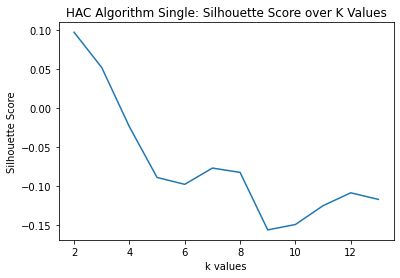

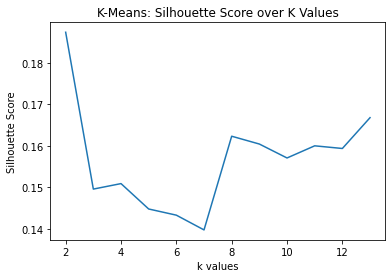

Best model: K-Means with 2.0 clusters


In [ ]:
# Clustering
df_test_model = df.copy()

# Run Clustering
model_cluster = sort_cluster_models(df_test_model)

# Save Best Model
dump_pickle(model_cluster,'saved_cluster_model.sav')
# model_upload = load_pickle('saved_classifier_model2.sav')
# model_upload.predict(df.drop(columns=['author_name']))